<h1 style="text-align: center;">CSC3066 Deep Learning (Fake News Detection)</h1>

<h6 style="margin: 0; padding:0; text-align: right;">Student Name: Ryan McKee</h6>
<h6 style="margin: 0; padding:0; text-align: right;">Student Number: 40294886</h6>
<h6 style="margin: 0; padding:0; text-align: right;">Date: 02/04/2024</h6>

<h5 style="margin: 0; padding: 0; text-align: left;"><u>Introduction</u></h5>

<h5 style="margin: 0; padding: 0; text-align: left;">
This notebook contains the implementation of four distinct approaches for the classification of the veracity of text utilizing neural networks. Supervised neural networks will be trained using the provided train.csv, consisting of 2000 labelled tweets, and evaluated using the 500 labelled tweets in the test.csv. Various methods of improving model performance will be explored, including preprocessing techniques for both training and test data, as well as model architecture and hyperparameter tuning. The document will present the best-performing version of the model after extensive experimentation with these techniques.

The model types being analyzed are as follows:

- The first is a Multi-Layer Perceptron (MLP) utilizing the training set, where each training data record is represented as a single vector derived from a pre-trained word embeddings vector.
- The second MLP will utilize the Keras Embedding layer to embed the training data in a pre-trained embedding model.
- The third will utilize a Convolutional Neural Network (CNN), where each record will be represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.
- The fourth will utilize a Recurrent Neural Network (RNN) model, where each record is represented as a sequence of pre-trained word embedding vectors, also using the Keras Embedding layer.
</h5>

<h5 style="margin: 0; padding: 0; text-align: left;"><u>Imports</u></h5>
<h5 style="margin: 0; padding: 0; text-align: left;">This section shows the imports for these two modesl. The MLP models will use numpy for matrix calculations, pandas for improting the datasets and tensorflow keras for data pre-processing through to the artificial neural networks creations. I have also imported the keyedvectors function for ...., re for text manipulation and nltk for pre-processing removing stop words and such</h5>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable GPU: Issues currently with GPU memory growth
# Config for GPU memory growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Initializer

from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import re 
import nltk


<h5><u>Data Loading</u></h5>

This section data loading is performed, Using the pandas library the training data (2000 text tweets), testing data (500 text tweets) and associated labels are loaded in as np.arrays using the pandas library. Then the pre-trained word embeddings vector representation for words are loaded in which will be used for embedding the words in our training and testing dataset so words in our sentences can be passed into our four different models.

In [18]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
X_train = df_training.values[:, 0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:, 0])
y_test = np.array(df_testing.values[:, 1], dtype=np.float32)

# Load the GLoVe word embeddings
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

<h5><u>Pre-processing - Cleaning the data</u></h5>
<h5>In this section I apply several pre-processing steps to clean the training and testing data from noise that would negatively affect the models ability to learn from the model. 

These steps include: 
- Removing special character's/words ( punctuation / urls )
- Remove stopwords any words that are contained within the sentence's that exist within the nltk.stopwords repository are removed from the sentences
- Perform lemmanzation: moving words to their roots for better text analysis.
</h5>

In [20]:
# Preprocess the data
# Preprocess the text: lowercase, remove special characters, tokenize
def remove_special_characters_and_tokenise(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = []
    for word in nltk.word_tokenize(text):
        tokens.extend(re.findall(r'\b\w+\b', word))  # Split combined words into separate tokens
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stopwords]

# Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Clean the sentence: Apply the cleaning process to a single sentence
def clean_sentence(sentence):
    tokens = remove_special_characters_and_tokenise(sentence)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    return tokens

# Preprocess the data: Apply the cleaning process to all sentences in data
def pre_process_data(data):
    token_arrays = []  
    for sentence in data:
        tokens = clean_sentence(sentence)
        token_arrays.append(np.array(tokens))

    return [' '.join(tokens) for tokens in token_arrays]

# Apply pre-processing to the training and testing data
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

<h3>Pre-processing: Machine learning Tokenization and padding</h3>

In this phase I will be performing keras machine learning tokenization of the training data and then padding the sentences so that each of the sentences have the same number of words as the machine as the MLP will always have the same number of neuron inputs. 

In [21]:
# Fit tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Tokenise the training data and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the training and test data sentences to the same length
max_len = max([len(x) for x in X_train]) 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## MLP with flattened glove embedded word vector

<h5><u>Manully embedding the tokenised training/testing data</u></h5>
<h5></h5>

In [22]:
# Convert tokenized words to glove embeddings
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

# Embed the training and test data
X_train_glove_embedded = embed_text_glove(X_train, tokenizer.word_index)
X_test_glove_embedded = embed_text_glove(X_test, tokenizer.word_index)

<h3>Applying glove embeddings to each of the tokenized words</h3>

In this flattened MLP phase I will be applying embedding each of the words within the X_train and X_test with their dimensions in the glove_embedding matrix.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 3)                 794703    
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 794,707
Trainable params: 794,707
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 4s 506ms/step - loss: 0.6680 - accuracy: 0.7056 - val_loss: 0.6239 - val_accuracy: 0.7825
Epoch 2/10
5/5 [==============================] - 1s 120ms/step - loss: 0.5850 - accuracy: 0.7919 - val_loss: 0.5612 - val_accuracy: 0.7675
Epoch 3/10
5/5 [==============================] - 1s 125ms/step - loss: 0.5163 - accuracy: 0.8206 - val_loss: 0.5151 - val_accuracy: 0.8025
Epoch 4/10
5/5 [========

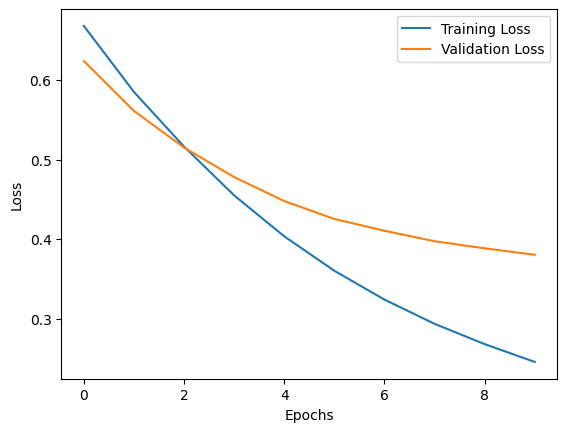

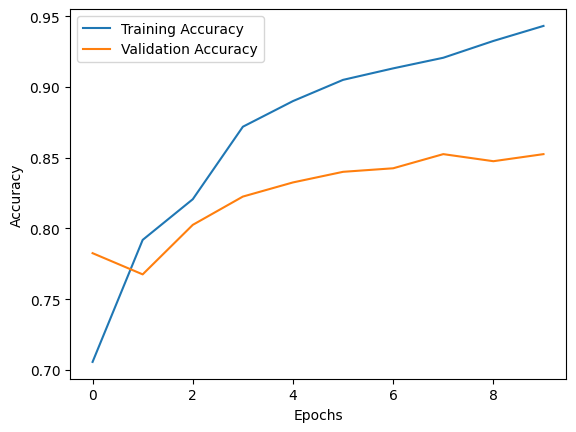

In [25]:
# Flatten the X_train_glove_embedded 2d array to a 1d array for input into the MLP
flattened_X_train = np.reshape(X_train_glove_embedded, (X_train_glove_embedded.shape[0], -1))

# Define the model
model_single_vector = Sequential()
model_single_vector.add(Dense(3, activation='relu', input_shape=(max_len * 300,))) # max_len is the length of the longest sentence and each word is 300 dimensions
# model_single_vector.add(Dense(3, activation='relu'))
model_single_vector.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model_single_vector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data with a validation split of 0.2
history = model_single_vector.fit(flattened_X_train, y_train, batch_size=320, epochs=10, validation_split=0.2)

# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h3>Make predications on the test data</h3>

(500, 883, 300)
(500, 264900)
16/16 [==============================] - 0s 5ms/step


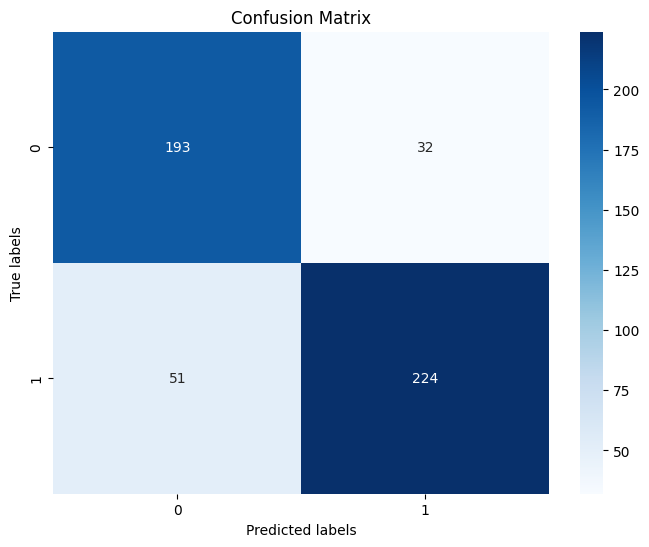

Accuracy: 0.834
Precision: 0.875
Recall: 0.8145454545454546
F1 Score: 0.8436911487758946


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

flattened_X_test = np.reshape(X_test_glove_embedded, (X_test_glove_embedded.shape[0], -1))
MLP_predications = model_single_vector.predict(flattened_X_test)
cm = confusion_matrix(y_test, MLP_predications.round())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate the accuracy, precision, recall and F1 score
accuracy = accuracy_score(y_test, MLP_predications.round())
precision = precision_score(y_test, MLP_predications.round())
recall = recall_score(y_test, MLP_predications.round())
f1 = f1_score(y_test, MLP_predications.round())

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

## MLP using keras embedding layer

<h3>Constructing the embedding matrix for the Embedding layer of the MLP<h3>

In this phase I will construct the embedding matrix for the embedding layer of the MLP this layer will convert a tokenized training set and testing set and convert it to it's glove embeddings then flatten it for input into the MLP

In [33]:
# Construct the model weight matrix for embedding layer
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove.key_to_index:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

<h3>Model Archetecture and compilation</h3>

883
7682
X_train:  (2000, 883)
y_train:  (2000,)
Epoch 1/30
50/50 - 4s - loss: 1.7448 - acc: 0.5044 - val_loss: 1.0882 - val_acc: 0.5125 - 4s/epoch - 72ms/step
Epoch 2/30
50/50 - 2s - loss: 1.0637 - acc: 0.5350 - val_loss: 1.0268 - val_acc: 0.4875 - 2s/epoch - 37ms/step
Epoch 3/30
50/50 - 2s - loss: 1.0135 - acc: 0.7556 - val_loss: 0.9445 - val_acc: 0.8375 - 2s/epoch - 36ms/step
Epoch 4/30
50/50 - 2s - loss: 0.8315 - acc: 0.8944 - val_loss: 0.8529 - val_acc: 0.8700 - 2s/epoch - 37ms/step
Epoch 5/30
50/50 - 2s - loss: 0.6762 - acc: 0.9469 - val_loss: 0.7526 - val_acc: 0.9000 - 2s/epoch - 37ms/step
Epoch 6/30
50/50 - 2s - loss: 0.5903 - acc: 0.9744 - val_loss: 0.7207 - val_acc: 0.8925 - 2s/epoch - 35ms/step
Epoch 7/30
50/50 - 2s - loss: 0.5417 - acc: 0.9837 - val_loss: 0.7092 - val_acc: 0.9000 - 2s/epoch - 34ms/step
Epoch 8/30
50/50 - 2s - loss: 0.5058 - acc: 0.9912 - val_loss: 0.6953 - val_acc: 0.8925 - 2s/epoch - 34ms/step
Epoch 9/30
50/50 - 2s - loss: 0.4770 - acc: 0.9937 - val_loss: 

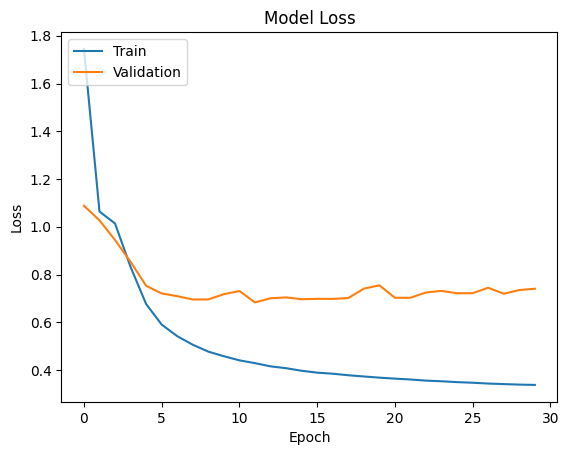

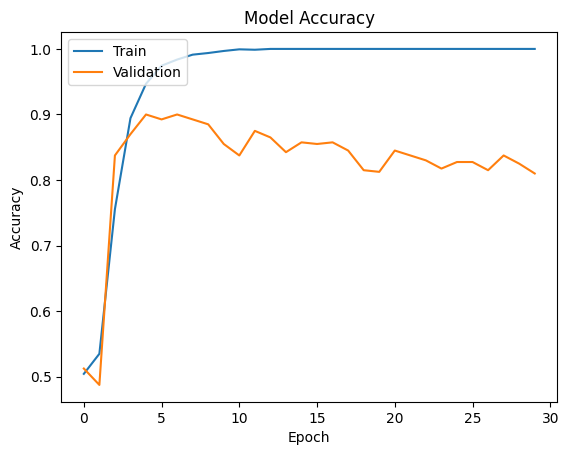

In [36]:
from tensorflow.keras.initializers import he_uniform

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

print (max_len)
print (vocab_size)

model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len))  # Specify input length here
model_2.add(Flatten())  # Specify input shape here
model_2.add(Dense(10, activation='relu', kernel_initializer=he_uniform(), kernel_regularizer=l1(0.001)))
model_2.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(0.001)))

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print ('X_train: ', X_train.shape)
print ('y_train: ', y_train.shape)
history = model_2.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=2)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h3>fit the model</h3>

16/16 [==============================] - 0s 9ms/step


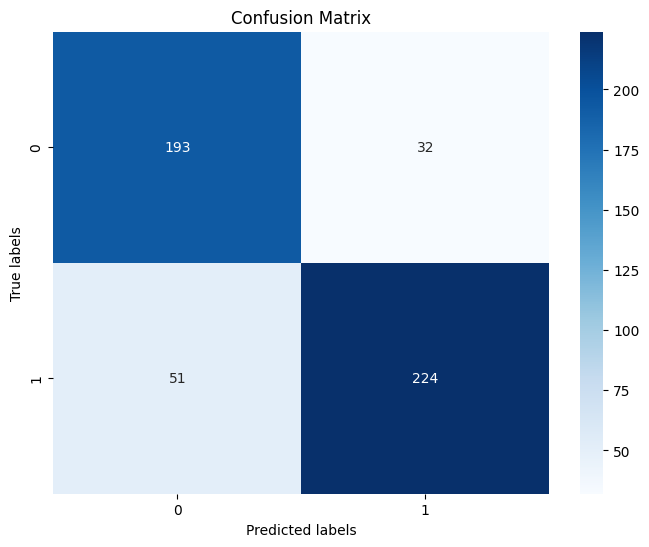

Accuracy: 0.834
Precision: 0.875
Recall: 0.8145454545454546
F1 Score: 0.8436911487758946


In [38]:
embedded_mlp_history = model_2.predict(X_test)

cm = confusion_matrix(y_test, MLP_predications.round())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate the accuracy, precision, recall and F1 score
accuracy = accuracy_score(y_test, MLP_predications.round())
precision = precision_score(y_test, MLP_predications.round())
recall = recall_score(y_test, MLP_predications.round())
f1 = f1_score(y_test, MLP_predications.round())

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")